# Household Location Choice Model (HLCM) for Single and Multi Family Housing  


Arezoo Besharati, Paul Waddell, UrbanSim, July 2018 

This notebook demonstrates the use of the LargeMultinomialLogit model template to construct, estimate, and evaluate a Household Location Choice Model for the San Francisco Bay Area.

In the process of developing the model, we also demonstrate some data checking and transformations to improve the model.

The model structure and specification are informed and limited by the available data, which is based on the data used by the Metropolitan Transportation Commission for their operational model.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminaries</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data</a></span></li></ul></li><li><span><a href="#Create-Additional-Household-and-Building-Variables" data-toc-modified-id="Create-Additional-Household-and-Building-Variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create Additional Household and Building Variables</a></span></li><li><span><a href="#Model-Estimation" data-toc-modified-id="Model-Estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Estimation</a></span><ul class="toc-item"><li><span><a href="#Initialize-rent_sqft-by-Running-the-Hedonic-Regression" data-toc-modified-id="Initialize-rent_sqft-by-Running-the-Hedonic-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Initialize rent_sqft by Running the Hedonic Regression</a></span></li><li><span><a href="#Check-Correlations" data-toc-modified-id="Check-Correlations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Check Correlations</a></span></li><li><span><a href="#Large-Choice-Set-Single-Family" data-toc-modified-id="Large-Choice-Set-Single-Family-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Large Choice Set Single-Family</a></span></li><li><span><a href="#Large-Choice-Set-Multi-Family" data-toc-modified-id="Large-Choice-Set-Multi-Family-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Large Choice Set Multi-Family</a></span></li></ul></li><li><span><a href="#Create-a-Chooser-Filter-and-Tag-Their-Buildings" data-toc-modified-id="Create-a-Chooser-Filter-and-Tag-Their-Buildings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create a Chooser Filter and Tag Their Buildings</a></span></li><li><span><a href="#Add-Flag-to-Buildings-Table-Identifying-Chosen-Buildings" data-toc-modified-id="Add-Flag-to-Buildings-Table-Identifying-Chosen-Buildings-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Add Flag to Buildings Table Identifying Chosen Buildings</a></span><ul class="toc-item"><li><span><a href="#Constrained-Choice-Set-Single_Family" data-toc-modified-id="Constrained-Choice-Set-Single_Family-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Constrained Choice Set Single_Family</a></span></li><li><span><a href="#Constrained-Choice-Set-Multi_Family" data-toc-modified-id="Constrained-Choice-Set-Multi_Family-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Constrained Choice Set Multi_Family</a></span></li></ul></li></ul></div>

## Preliminaries

In [1]:
import os; os.chdir('../../')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
mm.initialize()

Loading model step 'hlcm_constrained_sf'
Loading model step 'hedonic_price_sqft_single_family'
Loading model step 'hedonic_price_sqft_multi_family'
Loading model step 'hedonic_rent_sqft'


### Load data

First we import data sources which contains the references to all the actual data sources.  Then we import models, which contains the code to initialize networks and do network aggregations.

In [3]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

Orca uses 'lazy evaluation' which means it won't load data until we do something that requires it.

In [4]:
orca.list_tables()

['parcels',
 'buildings',
 'craigslist',
 'rentals',
 'nodessmall',
 'nodeswalk',
 'units',
 'households',
 'persons',
 'jobs']

Orca also uses 'broadcasts' to explitly indicate the merge relationships for doing table merges.

In [5]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons'),
 ('nodeswalk', 'rentals'),
 ('nodeswalk', 'parcels'),
 ('nodessmall', 'rentals'),
 ('nodessmall', 'parcels')]

## Create Additional Household and Building Variables

In [6]:
# scale income and create race dummies
hh = orca.get_table('households').to_frame()
hh.income_k = hh.income/1000
hh.white = (hh.race_of_head == 1).astype(int)
hh.black = (hh.race_of_head == 2).astype(int)
hh.asian = (hh.race_of_head == 6).astype(int)
hh.hisp = (hh.hispanic_head == 'yes').astype(int)
hh.single = (hh.persons == 1).astype(int)
hh.elderly = (hh.age_of_head > 65).astype(int)
hh.rich = (hh.income > 150000).astype(int)
hh.poor = (hh.income < 40000).astype(int)
hh.has_children = (hh.children > 0).astype(int)
  
# building_type dummies
bld = orca.get_table('buildings').to_frame()
bld.single_family = (bld.building_type_id == 1).astype(int)
bld.multi_family = (bld.building_type_id == 3).astype(int)
bld.mixed_use = (bld.building_type_id > 3).astype(int)
bld.two_four_stories = ((bld.stories > 1) & (bld.stories < 5)).astype(int)
bld.five_six_stories = ((bld.stories > 5) & (bld.stories < 7)).astype(int)
bld.sevenplus_stories = (bld.stories > 6).astype(int)
bld.yrblt_2000 = (bld.year_built > 2000).astype(int)
bld.two_four_new = (bld.yrblt_2000 * bld.two_four_stories).astype(int)
bld.five_six_new = (bld.yrblt_2000 * bld.five_six_stories).astype(int)
bld.sevenplus_new = (bld.yrblt_2000 * bld.sevenplus_stories).astype(int)
bld.three_plus_stories = (bld.stories > 2).astype(int)

# add the columns

orca.add_column('households', 'income_k', hh.income_k)
orca.add_column('households', 'white', hh.white)
orca.add_column('households', 'black', hh.black)
orca.add_column('households', 'asian', hh.asian)
orca.add_column('households', 'hispanic', hh.hisp)
orca.add_column('households', 'elderly', hh.elderly)
orca.add_column('households', 'rich', hh.rich)
orca.add_column('households', 'poor', hh.poor)
orca.add_column('households', 'has_children', hh.has_children)
orca.add_column('households', 'single', hh.single)

orca.add_column('buildings', 'single_family', bld.single_family)
orca.add_column('buildings', 'multi_family', bld.multi_family)
orca.add_column('buildings', 'mixed_use', bld.mixed_use)
orca.add_column('buildings', 'two_four_stories', bld.two_four_stories)
orca.add_column('buildings', 'five_six_stories', bld.five_six_stories)
orca.add_column('buildings', 'yrblt_2000', bld.yrblt_2000)
orca.add_column('buildings', 'two_four_new', bld.two_four_new)
orca.add_column('buildings', 'five_six_new', bld.five_six_new)
orca.add_column('buildings', 'sevenplus_new', bld.sevenplus_new)
orca.add_column('buildings', 'three_plus_stories', bld.three_plus_stories)

In [7]:
# Assign a random number to each household (with a fixed seed) to be able to select random samples
np.random.seed(12345)
hh['hh_random'] = np.random.uniform(0,1,len(hh))
orca.add_column('households', 'hh_random', hh.hh_random)

In [12]:
nodeswalk = orca.get_table('nodeswalk').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()

In [25]:
nodeswalk['pop_jobs_ratio_1500_walk'] = (nodeswalk['pop_1500_walk'] / (nodeswalk['jobs_500_walk'])).fillna(0)
nodessmall['pop_jobs_ratio_10000'] = (nodessmall['pop_10000'] / (nodessmall['jobs_10000'])).fillna(0)
nodessmall['pop_jobs_ratio_25000'] = (nodessmall['pop_25000'] / (nodessmall['jobs_25000'])).fillna(0)
nodeswalk['avg_hhs_500_walk'] = (nodeswalk['pop_500_walk'] / (nodeswalk['hh_500_walk'])).fillna(0)
nodeswalk['avg_hhs_1500_walk'] = (nodeswalk['pop_1500_walk'] / (nodeswalk['hh_1500_walk'])).fillna(0)

nodeswalk['pop_jobs_ratio_1500_walk'][nodeswalk['pop_jobs_ratio_1500_walk'] == np.inf] = 0
nodessmall['pop_jobs_ratio_10000'][nodessmall['pop_jobs_ratio_10000'] == np.inf] = 0
nodessmall['pop_jobs_ratio_25000'][nodessmall['pop_jobs_ratio_25000'] == np.inf] = 0
nodeswalk['pop_jobs_ratio_1500_walk'][nodeswalk['pop_jobs_ratio_1500_walk'] == np.inf] = 0
nodeswalk['avg_hhs_500_walk'][nodeswalk['avg_hhs_500_walk'] == np.inf] = 0
nodeswalk['avg_hhs_1500_walk'][nodeswalk['avg_hhs_1500_walk'] == np.inf] = 0

orca.add_column('nodeswalk', 'pop_jobs_ratio_1500_walk', nodeswalk.pop_jobs_ratio_1500_walk)
orca.add_column('nodessmall', 'pop_jobs_ratio_10000', nodessmall.pop_jobs_ratio_10000)
orca.add_column('nodessmall', 'pop_jobs_ratio_25000', nodessmall.pop_jobs_ratio_25000)
orca.add_column('nodeswalk', 'avg_hhs_500_walk', nodeswalk.avg_hhs_500_walk)
orca.add_column('nodeswalk', 'avg_hhs_1500_walk', nodeswalk.avg_hhs_1500_walk)


In [26]:
nodeswalk.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
units_500_walk,619889.00,238.93,377.17,0.00,5.00,91.00,318.00,2317.12
sqft_unit_500_walk,619889.00,1221.43,864.01,0.00,449.75,1327.47,1760.37,3698.59
singles_500_walk,619889.00,59.38,125.91,0.00,0.00,13.00,61.00,868.00
elderly_hh_500_walk,619889.00,39.19,61.74,0.00,0.00,15.00,52.00,363.00
children_500_walk,619889.00,110.65,151.64,0.00,1.00,46.00,164.00,755.00
units_sf_500_walk,619889.00,116.08,149.80,0.00,2.00,52.00,179.00,719.00
units_mf_500_walk,619889.00,107.51,257.35,0.00,0.00,0.00,86.00,1654.00
pop_500_walk,619889.00,543.32,783.63,0.00,11.00,224.00,770.00,4352.12
hh_500_walk,619889.00,212.32,333.00,0.00,4.00,81.00,284.00,2045.00
poor_500_walk,619889.00,55.35,105.98,0.00,0.00,13.00,59.00,643.00


## Model Estimation

### Initialize rent_sqft by Running the Hedonic Regression

Note below the use of modelmanager to get the regression model step we registered earlier, from yaml.  We then update some attributes of the model to switch from estimating the model on rental listings, to using the fitted model to predict rent_sqft on buildings

In [8]:
mrent = mm.get_step('hedonic_rent_sqft')
mrent.tables = ['buildings', 'parcels', 'nodessmall', 'nodeswalk']
mrent.out_filters = ['residential_units > 0']
mrent.out_column = 'rent_sqft'
mrent.tables

['buildings', 'parcels', 'nodessmall', 'nodeswalk']

In [9]:
bld = orca.get_table('buildings').to_frame()
bld['rent_sqft'] = 0
orca.add_table('buildings', bld)

In [10]:
%%time
mrent.run()

CPU times: user 23 s, sys: 4.74 s, total: 27.8 s
Wall time: 16.9 s


### Check Correlations

In [28]:
df = orca.merge_tables(target = 'buildings', tables = ['buildings','parcels','nodeswalk','nodessmall'])
#df.columns.tolist()
df_sf= df[df['residential_units']==1]
df_mf= df[df['residential_units']>1]

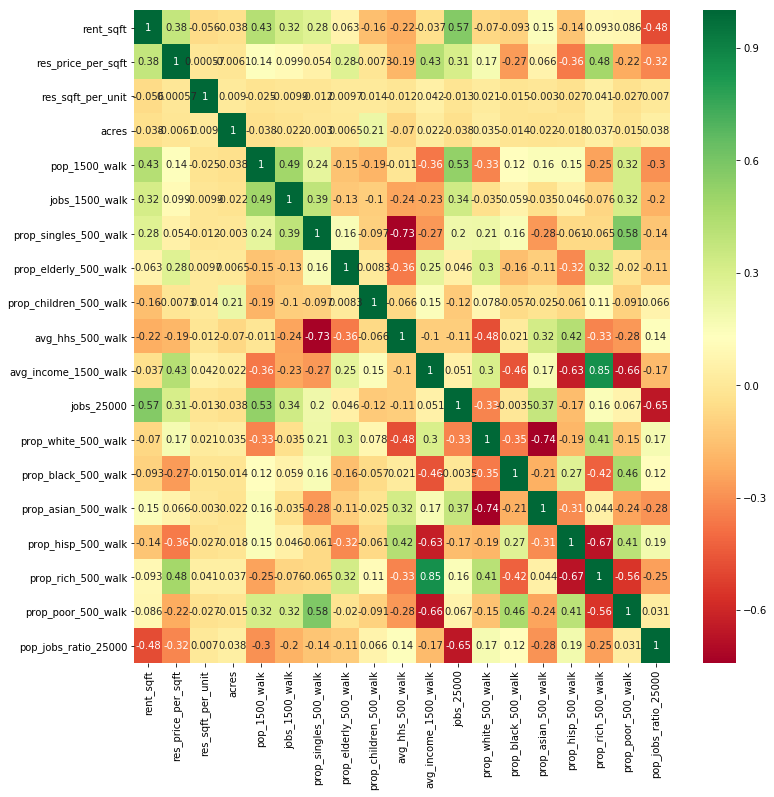

In [32]:
# Examine Single Family model variables
%matplotlib inline

selected_features = ['rent_sqft', 'res_price_per_sqft','res_sqft_per_unit',
                     'acres', 'pop_1500_walk', 'jobs_1500_walk',
                     'prop_singles_500_walk','prop_elderly_500_walk',
                     'prop_children_500_walk', 'avg_hhs_500_walk',
                     'avg_income_1500_walk', 
                     'jobs_25000','prop_white_500_walk','prop_black_500_walk',
                     'prop_asian_500_walk',
                     'prop_hisp_500_walk','prop_rich_500_walk','prop_poor_500_walk',
                     'pop_jobs_ratio_25000']

X = df_sf[selected_features]

plt.subplots(figsize=(12, 12))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

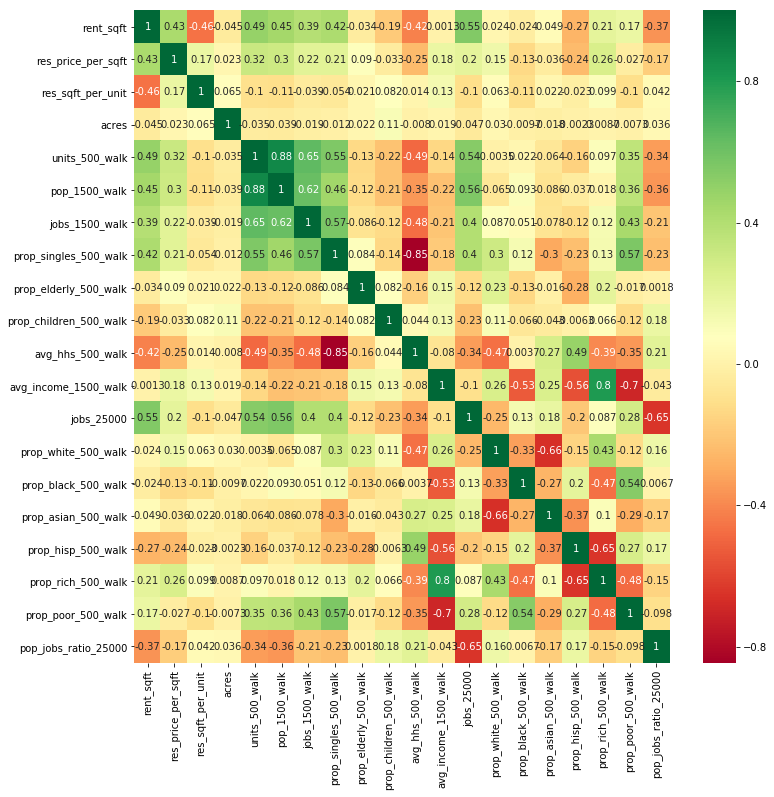

In [37]:
%matplotlib inline

selected_features = ['rent_sqft', 'res_price_per_sqft','res_sqft_per_unit',
                     'acres', 'units_500_walk', 'pop_1500_walk', 'jobs_1500_walk',
                     'prop_singles_500_walk','prop_elderly_500_walk',
                     'prop_children_500_walk', 'avg_hhs_500_walk',
                     'avg_income_1500_walk', 
                     'jobs_25000','prop_white_500_walk','prop_black_500_walk',
                     'prop_asian_500_walk',
                     'prop_hisp_500_walk','prop_rich_500_walk','prop_poor_500_walk',
                     'pop_jobs_ratio_25000']

X = df_mf[selected_features]

plt.subplots(figsize=(12, 12))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Large Choice Set Single-Family 

In [32]:
%%time
m1 = LargeMultinomialLogitStep()
m1.choosers = ['households']
m1.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m1.choice_column = 'building_id'
m1.alt_sample_size = 50

#Filters on choosers
m1.chooser_filters = ['building_type == 2 & recent_mover == 1 & 0 <income < 1000000']

#Filters on alternatives
m1.alt_filters = ['residential_units == 1',
                 '0 < avg_income_500_walk < 500000',
                 'sqft_per_unit > 0']


m1.model_expression = ' \
np.log1p(rent_sqft) + \
np.log(income):np.log1p(rent_sqft) + \
np.log(jobs_25000+1) + \
np.log1p(pop_jobs_ratio_25000) + \
rich:prop_rich_500_walk + \
poor:prop_poor_500_walk + \
single:prop_singles_500_walk + \
elderly:prop_elderly_500_walk + \
white:prop_white_500_walk + \
black:prop_black_500_walk + \
asian:prop_asian_500_walk + \
hispanic:prop_hisp_500_walk\
- 1'

m1.name = 'hlcm'
m1.tags = ['single_family', 'test']
m1.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:         15,768
Model:         Multinomial Logit   Df Residuals:             15,756
Method:       Maximum Likelihood   Df Model:                     12
Date:                 2018-07-26   Pseudo R-squ.:             0.122
Time:                      08:52   Pseudo R-bar-squ.:         0.122
AIC:                 108,360.644   Log-Likelihood:      -54,168.322
BIC:                 108,452.633   LL-Null:             -61,684.779
                                        coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------
np.log1p(rent_sqft)                  -4.5328     0.176   -25.706     0.000             
np.log(income):np.log1p(rent_sqft)    0.3664     0.015    24.851     0.000             
np.log(jobs_25000 + 1)                0.0802     0.005    16.816     0.000             
np.log1p(pop_job

### Large Choice Set Multi-Family 

In [33]:
%%time
m2 = LargeMultinomialLogitStep()
m2.choosers = ['households']
m2.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m2.choice_column = 'building_id'
m2.alt_sample_size = 50

#Filters on choosers
m2.chooser_filters = ['building_type > 2 &\
                      recent_mover == 1 &\
                      hh_random < .5 & \
                      persons < 8 & \
                      workers < 4 & \
                      0 <income < 500000']

#Filters on alternatives
m2.alt_filters = ['residential_units > 1',
                 '0 < avg_income_500_walk < 500000',
                 '0 < rent_sqft < 1000',
                 'pop_1500_walk > 0',
                 'res_price_per_sqft < 1500',
                 'res_sqft_per_unit < 6000',
                 'residential_units < 1000',
                 'sqft_per_unit > 0']


m2.model_expression = ' np.log(residential_units) + \
np.log1p(rent_sqft) + \
np.log(income):np.log1p(rent_sqft) + \
np.log1p(units_500_walk) + \
np.log1p(jobs_25000) + \
np.log1p(pop_jobs_ratio_25000) + \
rich:prop_rich_500_walk + \
poor:prop_poor_500_walk + \
single:prop_singles_500_walk + \
elderly:prop_elderly_500_walk + \
white:prop_white_500_walk + \
black:prop_black_500_walk + \
asian:prop_asian_500_walk + \
hispanic:prop_hisp_500_walk\
- 1'

m2.name = 'hlcm'
m2.tags = ['multi_family','test']
m2.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:         23,600
Model:         Multinomial Logit   Df Residuals:             23,586
Method:       Maximum Likelihood   Df Model:                     14
Date:                 2018-07-26   Pseudo R-squ.:             0.413
Time:                      08:54   Pseudo R-bar-squ.:         0.413
AIC:                 108,468.782   Log-Likelihood:      -54,220.391
BIC:                 108,581.749   LL-Null:             -92,323.743
                                        coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------
np.log(residential_units)             1.2012     0.005   218.746     0.000             
np.log1p(rent_sqft)                  -2.8999     0.102   -28.376     0.000             
np.log(income):np.log1p(rent_sqft)    0.2572     0.009    29.403     0.000             
np.log1p(units_5

## Create a Chooser Filter and Tag Their Buildings

Here we create a flag on the buildings table to identify which buildings our filtered choosers are located in.  We will use this later to constrain the universal choice set for model estimation to  these buildings.  This is an effort to approximate both the choice set that these recent_movers actually had available to them in the market when they were searching, and also to approximate the way that the simulation will work: with only units that are vacant being used to create the universal choice set.  Note that in general practice this restriction has not been used.  Our testing suggests that the constraint provides more realistic results.

In [35]:
hh = orca.get_table('households').to_frame()

# Apply the filtering we will use when we estimate the single family model
hh_sf = hh[(hh['building_type'] == 2)  & (hh['recent_mover'] == 1) \
         & (hh['income'] > 0) & (hh['income'] < 1000000)]
sf_tmp = pd.DataFrame(hh_sf.building_id.unique(), columns=['building_id'])
sf_tmp['sf_choice_set'] = 1
sf_tmp = sf_tmp.set_index('building_id')

# Apply the filtering we will use when we estimate the multi family model
hh_mf = hh[(hh['building_type'] > 2) &  (hh['hh_random'] < .5) & (hh['recent_mover'] == 1) \
         & (hh['income'] > 0) & (hh['income'] < 500000)]
mf_tmp = pd.DataFrame(hh_mf.building_id.unique(), columns=['building_id'])
mf_tmp['mf_choice_set'] = 1
mf_tmp = mf_tmp.set_index('building_id')

## Add Flag to Buildings Table Identifying Chosen Buildings

In [36]:
bld = orca.get_table('buildings').to_frame()
bld2 = bld.merge(sf_tmp, how='left', left_index=True, right_index=True)
bld2.sf_choice_set= bld2.sf_choice_set.fillna(0)
bld3 = bld2.merge(mf_tmp, how='left', left_index=True, right_index=True)
bld3.mf_choice_set= bld3.mf_choice_set.fillna(0)
bld = bld3
orca.add_column('buildings', 'sf_choice_set', bld.sf_choice_set)
orca.add_column('buildings', 'mf_choice_set', bld.mf_choice_set)

### Constrained Choice Set Single_Family

In [37]:
%%time
m3 = LargeMultinomialLogitStep()
m3.choosers = ['households']
m3.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m3.choice_column = 'building_id'
m3.alt_sample_size = 50

#Filters on choosers
m3.chooser_filters = ['building_type == 2 & recent_mover == 1 & 0 <income < 1000000']

m3.alt_filters = ['sf_choice_set == 1 & sqft_per_unit > 0']

# np.log(residential_units) +
# np.log(income):np.log(avg_income_500_walk) + \
# np.log1p(income):np.log1p(rich_1500_walk) + \
# np.log1p(income):np.log1p(poor_1500_walk) + \
# np.log1p(persons):np.log1p(sqft_per_unit) + \

#np.log1p(res_price_per_sqft) + \
#np.log1p(income):np.log1p(res_price_per_sqft) + \


m3.model_expression = ' \
np.log1p(rent_sqft) + \
np.log(income):np.log1p(rent_sqft) + \
np.log(jobs_25000+1) + \
np.log1p(pop_jobs_ratio_25000) + \
rich:prop_rich_500_walk + \
poor:prop_poor_500_walk + \
single:prop_singles_500_walk + \
elderly:prop_elderly_500_walk + \
white:prop_white_500_walk + \
black:prop_black_500_walk + \
asian:prop_asian_500_walk + \
hispanic:prop_hisp_500_walk\
- 1'

m3.name = 'hlcm_constrained_sf'
m3.tags = ['single_family', 'constrained']
m3.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:         22,458
Model:         Multinomial Logit   Df Residuals:             22,446
Method:       Maximum Likelihood   Df Model:                     12
Date:                 2018-07-26   Pseudo R-squ.:             0.103
Time:                      08:57   Pseudo R-bar-squ.:         0.103
AIC:                 157,574.243   Log-Likelihood:      -78,775.121
BIC:                 157,670.476   LL-Null:             -87,856.213
                                        coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------
np.log1p(rent_sqft)                  -4.4495     0.142   -31.280     0.000             
np.log(income):np.log1p(rent_sqft)    0.3949     0.012    33.300     0.000             
np.log(jobs_25000 + 1)                0.0369     0.004     9.215     0.000             
np.log1p(pop_job

In [25]:
# register the model
m3.register()

Saving 'hlcm_constrained_sf.yaml': /Users/paul/src/urbansim_parcel_bayarea/configs
Loading model step 'hlcm_constrained_sf'


### Constrained Choice Set Multi_Family

In [39]:
%%time
m4 = LargeMultinomialLogitStep()
m4.choosers = ['households']
m4.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m4.choice_column = 'building_id'
m4.alt_sample_size = 50

#Filters on choosers
m4.chooser_filters = ['building_type > 2 & \
                      hh_random < .5 & \
                      recent_mover == 1 & \
                      persons < 8 & \
                      workers < 4 & \
                      0 <income < 500000']

#Filters on alternatives
m4.alt_filters = ['residential_units > 1',
                 '0 < avg_income_500_walk < 500000',
                 '0 < rent_sqft < 1000',
                 'res_sqft_per_unit < 6000',
                  'sqft_per_unit > 0',
                  'residential_units < 1000',
                 'mf_choice_set == 1']

m4.model_expression = ' np.log(residential_units) + \
np.log1p(rent_sqft) + \
np.log(income):np.log1p(rent_sqft) + \
np.log1p(units_500_walk) + \
np.log1p(jobs_25000) + \
np.log1p(pop_jobs_ratio_25000) + \
rich:prop_rich_500_walk + \
poor:prop_poor_500_walk + \
single:prop_singles_500_walk + \
elderly:prop_elderly_500_walk + \
white:prop_white_500_walk + \
black:prop_black_500_walk + \
asian:prop_asian_500_walk + \
hispanic:prop_hisp_500_walk\
- 1'

m4.name = 'hlcm_constrained_mf'
m4.tags = ['multi_family','constrained', 'hlcm']
m4.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:         24,501
Model:         Multinomial Logit   Df Residuals:             24,487
Method:       Maximum Likelihood   Df Model:                     14
Date:                 2018-07-26   Pseudo R-squ.:             0.132
Time:                      09:02   Pseudo R-bar-squ.:         0.132
AIC:                 166,453.812   Log-Likelihood:      -83,212.906
BIC:                 166,567.303   LL-Null:             -95,848.476
                                        coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------
np.log(residential_units)             0.4475     0.004   111.188     0.000             
np.log1p(rent_sqft)                  -1.8693     0.087   -21.532     0.000             
np.log(income):np.log1p(rent_sqft)    0.1404     0.007    18.838     0.000             
np.log1p(units_5

In [40]:
# register the model
m4.register()

Saving 'hlcm_constrained_mf.yaml': /Users/paul/src/urbansim_parcel_bayarea/configs
Loading model step 'hlcm_constrained_mf'


In [41]:
tmp = m4.mergedchoicetable.to_frame()

In [42]:
tmp.head()

,building_id,parcel_id,development_type_id,improvement_value,residential_units,residential_sqft,sqft_per_unit,non_residential_sqft,building_sqft,nonres_rent_per_sqft,...,black,asian,hispanic,elderly,rich,poor,has_children,single,hh_random,chosen
0,1579650,1546676,2.00,149975.00,15.00,21225.00,1415.00,0.00,21225.00,0.00,...,0,1,0,0,0,1,0,1,0.40,1
1,1533082,1552321,2.00,349885.02,3.00,3492.00,1164.00,0.00,3492.00,0.00,...,0,1,0,0,0,1,0,1,0.40,0
2,1250120,912201,1.00,10569.00,2.00,3600.00,1800.00,0.00,3600.00,0.00,...,0,1,0,0,0,1,0,1,0.40,0
3,920563,297941,1.00,0.00,6.00,9982.00,1663.78,0.00,9982.69,0.00,...,0,1,0,0,0,1,0,1,0.40,0
4,836918,1237210,2.00,31219623.00,119.00,148631.00,1249.00,0.00,148631.00,0.00,...,0,1,0,0,0,1,0,1,0.40,0


In [45]:
chosen = tmp[tmp['chosen']==1]

In [47]:
chosen.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
building_id,24501.00,921131.07,526000.90,718.00,465787.00,921514.00,1409973.00,1834225.00
parcel_id,24501.00,915820.12,525135.30,175.00,446802.00,957015.00,1320726.00,2054457.00
development_type_id,24501.00,2.75,3.99,1.00,2.00,2.00,2.00,24.00
improvement_value,24501.00,7308515.17,21120290.57,0.00,182695.03,490000.00,4878438.00,399670613.00
residential_units,24501.00,72.87,124.35,2.00,4.00,15.00,88.00,991.00
residential_sqft,24501.00,79501.73,155803.78,520.00,4533.00,16800.00,83179.00,1850486.00
sqft_per_unit,24501.00,1224.78,731.29,200.00,750.00,1011.18,1600.00,5999.00
non_residential_sqft,24501.00,5254.60,52495.73,0.00,0.00,0.00,0.00,1479817.00
building_sqft,24501.00,83766.80,164960.27,520.00,4612.00,17508.33,89844.21,1850486.00
nonres_rent_per_sqft,24501.00,0.00,0.20,0.00,0.00,0.00,0.00,31.96
